<h3>Overview</h3>
<p>This notebook aims to build a model to classify quark and gluon jet events using Graph Neural Networks (GNNs).</p>
<p>The quark and gluon jet events are represented as 125x125 images with three channels (ECAL, HCAL, and Tracks). These images are first converted into graphs. A GNN model is then constructed to perform graph-level classification.</p>
<p>The network consists of two parts: the first part learns graph representations using contrastive learning, while the second part is a classifier that classifies events based on the representations learned in the first part.</p>

In [1]:
#%pip install torch_geometric
#%pip install networkx
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import h5py
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random
import torch.nn as nn
from torch_geometric.nn import GCNConv, TopKPooling, SAGEConv, SAGPooling, global_mean_pool
import torch.nn.functional as F
from matplotlib import pyplot as plt

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Data Preparation</h3>
<p>In the preprocessing phase, images are converted to graph representations by first considering only non-zero pixels. Then the k-nearest neighbors algorithm is applied to determine edges between the nodes.</p>
<p>Each node in the graph corresponds to a non-zero pixel in the image. Every node is assigned five features: x-coordinate, y-coordinate, ECAL, HCAL, and Tracks.</p>
<p>Quark_Gluon_Dataset is a custom dataset class that is derived from the torch.utils.data.Dataset class in PyTorch.

This class is used to define a dataset that contains images from Quark/Gluon jet events. 

The input images are normalized based on their mean and standard deviation. Normalization ensures that the model is less sensitive to pixel value variations, which helps prevent numerical instabilities and allows the optimizer to converge more quickly.</p>

In [2]:
class Quark_Gluon_Dataset_v2(Dataset):
    def __init__(self, start,train_data_size):
        with h5py.File('data/quark-gluon_data-set_n139306.hdf5', 'r') as f:
            print(f.keys())
            self.X_jets_data = f['X_jets'][start:train_data_size]
            self.y_data = f['y'][start:train_data_size]
            self.transform = transforms.Compose([transforms.ToTensor()])
            self.graphs, self.augmented_graphs, self.labels = self.process_data()

        f.close()
        del f

    def create_graph_data_v3(self, x_jet, x_jet_normalized, y):
        none_zero_point_cloud = []
        graph = []
        for i in range(len(x_jet[0])):
            for j in range(len(x_jet[0][i])):
                if x_jet[0][i][j] != 0 or x_jet[1][i][j] != 0 or x_jet[2][i][j] != 0:
                    none_zero_point_cloud.append(
                        [i, j, x_jet_normalized[i][j][0], x_jet_normalized[i][j][1], x_jet_normalized[i][j][2]])

        # Compute the k-NN graph using the point cloud
        xy_coordinates = [x[:2] for x in none_zero_point_cloud]
        # nbrs = NearestNeighbors(radius=5, algorithm='ball_tree').fit(xy_coordinates)
        # distances, indices = nbrs.radius_neighbors(xy_coordinates)
        nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(none_zero_point_cloud)
        distances, indices = nbrs.kneighbors(none_zero_point_cloud)

        edges = []
        for i, node in enumerate(indices):
            for j, neigbour in enumerate(node):
                if i != j:
                    edges.append([i, j, distances[i][j]])

        x = torch.tensor(none_zero_point_cloud, dtype=torch.float)
        edge_index = torch.tensor([x[:2] for x in edges], dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor([x[2] for x in edges], dtype=torch.float)
        y = torch.tensor(int(y), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        return data, edges    

    def get_augment_graph(self, graph, edges, remove_percent):
        augment_edges = edges.copy()
        
        max_nodes = int(len(augment_edges) * remove_percent)
        if max_nodes > 1:
            num_nodes_to_remove = random.randrange(1, max_nodes)

            for i in range(num_nodes_to_remove):
                if len(augment_edges)>0:
                    index = random.randrange(0, len(augment_edges))
                    del(augment_edges[index])

        edge_index = torch.tensor([x[:2] for x in augment_edges], dtype=torch.long).t().contiguous()

        return Data(x=graph.x, edge_index=edge_index)

    def process_data(self):
        graphs = []
        augmented_graphs = []
        labels = []
        counter = 0
        for x_jet, y in zip(self.X_jets_data, self.y_data):
            counter+=1
            mean = np.mean(x_jet, axis=(0, 1))
            std = np.std(x_jet, axis=(0, 1))
            x_jet_normalized = (x_jet - mean) / std
            x_jet_tensor = self.transform(x_jet)
            x_jet_data, edges = self.create_graph_data_v3(x_jet_tensor,x_jet_normalized ,y)

            if len(edges) < 10:
                print("graph with a few edges")
                continue

            x_jet_augment_data = self.get_augment_graph(x_jet_data, edges, 0.001)

            y = torch.tensor(int(y), dtype=torch.long)

            graphs.append(x_jet_data)
            augmented_graphs.append(x_jet_augment_data)
            labels.append(y)

        return graphs, augmented_graphs, labels


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):


        return self.graphs[index], self.augmented_graphs[index], self.labels[index]



<h3>Contrastive Learning Network Architecture</h3>
<p>This neural network atchitecture consists of two parts. The first part is a Graph Neural Network that is based on the contrastive learning paradigm and aims to learn graph embeddings. The second part is a classifier that classifies jet events based the learned embeddings from the first one. </p>

In [3]:
class GraphContrastiveNetDeeperSageBatch(nn.Module):
    def __init__(self, feat_dim, hidden_dim, emb_dim, num_classes):
        super(GraphContrastiveNetDeeperSageBatch, self).__init__()
        
        self.sage1 = SAGEConv(feat_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=0.8)
        self.sage2 = SAGEConv(hidden_dim, emb_dim)
        self.bn2 = nn.BatchNorm1d(emb_dim)
        self.pool2 = TopKPooling(emb_dim, ratio=0.8)

        #self.fc = nn.Linear(emb_dim, num_classes)
        # Deeper classifier
        # self.classifier_hidden1 = nn.Linear(emb_dim, emb_dim // 2)
        # self.classifier_hidden2 = nn.Linear(emb_dim // 2, emb_dim // 4)
        # self.classifier_output = nn.Linear(emb_dim // 4, num_classes)
        self.classifier_hidden1 = nn.Linear(emb_dim, emb_dim)
        self.classifier_hidden2 = nn.Linear(emb_dim , emb_dim//2)
        self.classifier_output = nn.Linear(emb_dim//2 , num_classes)

    def forward(self, x, edge_index, batch):
        # x, edge_index, batch = data.x, data.edge_index, data.batch
        # x = x.to(self.device)
        # edge_index = edge_index.to(self.device)
        # batch = batch.to(self.device)
        x = self.sage1(x, edge_index)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x = self.sage2(x, edge_index)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x = global_mean_pool(x, batch)


        #return x, batch
        return x

    def classify(self,x):
        x = F.relu(self.classifier_hidden1(x))
        x = F.relu(self.classifier_hidden2(x))
        x = self.classifier_output(x)
        return x

    def pool(self, x, batch):
        return global_mean_pool(x, batch)


# Define the contrastive loss function
class InfoNCELoss(nn.Module):
    def __init__(self, temperature):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        # Compute positive pair similarity
        sim_pos = torch.exp(torch.sum(z_i * z_j, dim=1) / self.temperature)

        # Compute negative pair similarity
        sim_neg = torch.mm(z_i, torch.transpose(z_j, 0, 1))
        sim_neg = torch.sum(torch.exp(sim_neg / self.temperature), dim=1)

        # Compute InfoNCE loss
        loss = -torch.log(sim_pos / (sim_pos + sim_neg))
        return loss.mean()



<h3>Training</h3>
<p>A GNN model is trained over 1000 samples. Please note that the dataset contains almost 13000 samples. However, due to limited computational power, I only considered a subset of samples for training. </p>
<p>Based on the contrastive loss values, the contrastive learning part is learninng. However, it seems the classifier is still struggling with this setting since the classifier loss is not decresing very much. I believe with more number samples and epochs and also after the contrastive part reachs to the point that it outputs more meaningful embeddings, the classifier will start to improve.</p>

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
Epoch: 1, Contrastive Loss: 1.2893807888031006, Classification Loss: 0.6693838834762573, Total Loss: 1.958764672279358
Epoch: 2, Contrastive Loss: 1.3495559692382812, Classification Loss: 0.6849379539489746, Total Loss: 2.034493923187256
Epoch: 3, Contrastive Loss: 1.14620041847229, Classification Loss: 0.7334892749786377, Total Loss: 1.8796896934509277
Epoch: 4, Contrastive Loss: 0.8165686130523682, Classification Loss: 0.6605863571166992, Total Loss: 1.4771549701690674
Epoch: 5, Contrastive Loss: 0.8894357681274414, Classification Loss: 0.8033169507980347, Total Loss: 1.692752718925476
Epoch: 6, Contrastive Loss: 0.8835732340812683, Classification Loss: 0.7474983334541321, Total Loss: 1.6310715675354004
Epoch: 7, Contrastive Loss: 1.0619266033172607, Classification Loss: 0.5989032983779907, Total Loss: 1.6608299016952515
Epoch: 8, Contrastive Loss: 0.8440003395080566, Classification Loss: 0.6921497583389282, Total Loss: 1.5361500978469849
Ep

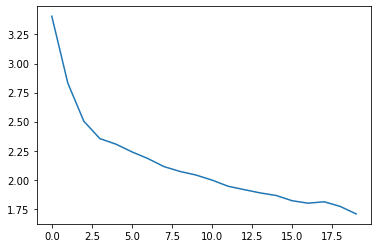

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
Accuracy: 0.5312
Accuracy: 0.6250
Accuracy: 0.6250
Accuracy: 0.6719
Accuracy: 0.6500
Accuracy: 0.6458
Accuracy: 0.6518
Accuracy: 0.6484
Accuracy: 0.6354
Accuracy: 0.6375
Accuracy: 0.6392
Accuracy: 0.6380
Accuracy: 0.6466
Accuracy: 0.6540
Accuracy: 0.6562
Accuracy: 0.6543
Accuracy: 0.6618
Accuracy: 0.6562
Accuracy: 0.6546
Accuracy: 0.6578
Accuracy: 0.6592
Accuracy: 0.6619
Accuracy: 0.6522
Accuracy: 0.6523
Accuracy: 0.6550
Accuracy: 0.6562
Accuracy: 0.6539
Accuracy: 0.6562
Accuracy: 0.6541
Accuracy: 0.6542
Accuracy: 0.6603
Accuracy: 0.6610


In [4]:
train_data_size = 1000
start = 0

dataset = Quark_Gluon_Dataset_v2(start,train_data_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
feat_dim = 5
hidden_dim = 128
emb_dim = 64
lr = 0.001
num_epochs = 20
num_classes = 2
tempurture = 0.8
device = ('cuda' if torch.cuda.is_available() else 'cpu')

loss_list = []
model = GraphContrastiveNetDeeperSageBatch(feat_dim, hidden_dim, emb_dim, num_classes)
model.to(device)
model.train()
classifier_criterion = nn.CrossEntropyLoss()
contrastive_criterion = InfoNCELoss(tempurture)
contrastive_criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    counter = 0
    batch_loss = 0
    for pos_graphs, neg_graphs, labels in dataloader:
        counter+=1
        labels = labels.to(device)
        x_pos, edge_index_pos, batch_pos = pos_graphs.x, pos_graphs.edge_index, pos_graphs.batch
        x_pos = x_pos.to(device)
        edge_index_pos = edge_index_pos.to(device)
        batch_pos = batch_pos.to(device)

        x_neg, edge_index_neg, batch_neg = neg_graphs.x, neg_graphs.edge_index, neg_graphs.batch
        x_neg = x_neg.to(device)
        edge_index_neg = edge_index_neg.to(device)
        batch_neg = batch_neg.to(device)

        z_i = model(x_pos, edge_index_pos, batch_pos)
        z_j = model(x_neg, edge_index_neg, batch_neg)

        contrastive_loss = contrastive_criterion(z_i,z_j)
        logits = model.classify(z_i)
        optimizer.zero_grad()
        classification_loss = classifier_criterion(logits,labels)
        loss = contrastive_loss + classification_loss
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()

    loss_list.append(batch_loss/counter)
    print(
        f"Epoch: {epoch + 1}, Contrastive Loss: {contrastive_loss.item()}, Classification Loss: {classification_loss.item()}, Total Loss: {loss.item()}")
plt.plot(loss_list)
plt.show()
model.to('cpu')
model.eval()
test_size = 100
dataset_test = Quark_Gluon_Dataset_v2(train_data_size,train_data_size+test_size)
testloader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for pos_data, neg_data, labels in testloader:
        x_pos, edge_index_pos, batch_pos = pos_data.x, pos_data.edge_index, pos_data.batch

        z_i = model(x_pos, edge_index_pos, batch_pos)
        logits = model.classify(z_i)
        preds = logits.argmax(dim=1)
        num_correct += (preds == labels).sum().item()
        num_samples += labels.size(0)

        acc = num_correct / num_samples
        print(f"Accuracy: {acc:.4f}")
